## Import libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import tikzplotlib

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_predict, validation_curve, learning_curve

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import mutual_info_regression

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from utils.preprocessing import preprocess_duplicated_and_missing, preprocess_irrelevant_features, one_hot_encode_genres_feature, one_hot_encode_studio_feature, remove_outliers, other_fixes, standardize
from utils.feature_extraction import extract_embeddings_features, pca_on_embeddings
from utils.feature_selection import get_mutual_information_matrix, normalize_mutual_information_matrix, select_features_MI_kbest, mrmr, select_features_RFECV
from utils.model_selection import linreg, ModelSelection
from utils.plots import plot_correlation_matrix, plot_mutual_information_matrix, plot_mutual_information_with_target

from utils.latex import set_size, set_size_square_plot

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

#import scienceplots
#plt.style.use("science")

In [2]:
# declare variables for model selection
N_SPLITS = 5

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
rmse = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

In [3]:
pd.set_option('display.max_columns', 50)

## Load datasets

In [4]:
def read_datasets():
	X1 = pd.read_csv("datasets/X1.csv", na_values="\\N")
	Y1 = pd.read_csv("datasets/Y1.csv", header=None, names=["revenues"])
	X2 = pd.read_csv("datasets/X2.csv", na_values="\\N")

	X1.drop("Unnamed: 0", axis=1, inplace=True)
	X2.drop("Unnamed: 0", axis=1, inplace=True)
	df = pd.concat([X1, Y1], axis = 1)

	print(f"X1 dataset contains {X1.shape[0]} observations and {X1.shape[1]} features")
	print(f"X2 dataset (for prediction only) contains {X2.shape[0]} observations")

	return df, X2

## Preprocessing

In [5]:
def preprocess(df, train, X2, dataset_name):
	print("-" * 25)
	print(f"PREPROCESSING {dataset_name}...")
	print("-" * 25)
	# remove duplicated observations and preprocessing missing values
	df = preprocess_duplicated_and_missing(df, train)
	# should not remove duplicated and missing values from X2
	# as Y2.csv should contains 1518 predictions
	#X2 = preprocess_duplicated_and_missing(X2, train)

	# remove (obvious) irrelevant/redundant features
	df = preprocess_irrelevant_features(df)
	X2 = preprocess_irrelevant_features(X2)

	# fix high-cardinality + one-hot-encode studio feature
	df, X2 = one_hot_encode_studio_feature(df, X2)

	# one-hot encode genres feature
	df, X2 = one_hot_encode_genres_feature(df, X2)

	# minor fixes
	df = other_fixes(df)
	X2 = other_fixes(X2)
	return df, X2

## Feature extraction and dimension reduction

In [6]:
def remove_outliers_and_split(X, Y):
	print("-" * 25)
	print("REMOVING OUTLIERS AND TRAIN-TEST SPLIT...")
	print("-" * 25)

	X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = 0)

	print(f"training dataset dimension: X_train: {X_train.shape}, y_train: {y_train.shape}")
	print(f"testing dataset dimension: X_test: {X_test.shape}, y_test: {y_test.shape}")

	# remove outliers only on train set
	# as test set should be representative of the reality
	X_train, y_train = remove_outliers(X_train, y_train, ["runtime", "production_year", "release_year"])

	return X_train, y_train, X_test, y_test

def extract_features(X_train, y_train, X_test, y_test, X2, run_pca=True, non_linear=True):
	print("-" * 25)
	print("FEATURE EXTRACTION...")
	print("-" * 25)

	# extract feature vectors
	X_train_img_embeddings = extract_embeddings_features(X_train["img_embeddings"])
	X_test_img_embeddings = extract_embeddings_features(X_test["img_embeddings"])

	X_train_text_embeddings = extract_embeddings_features(X_train["text_embeddings"])
	X_test_text_embeddings = extract_embeddings_features(X_test["text_embeddings"])

	# should also extract features for X2
	X2_img_embeddings = extract_embeddings_features(X2["img_embeddings"])
	X2_text_embeddings = extract_embeddings_features(X2["text_embeddings"])

	X_train_img_df, X_test_img_df, X2_img_df = pca_on_embeddings(X_train_img_embeddings, X_test_img_embeddings, X2_img_embeddings, X_train.index, X_test.index, X2.index, prefix="img_feature", n_components=5, run_pca=run_pca, non_linear=non_linear)

	X_train_text_df, X_test_text_df, X2_text_df = pca_on_embeddings(X_train_text_embeddings, X_test_text_embeddings, X2_text_embeddings, X_train.index, X_test.index, X2.index, prefix="text_feature", n_components=5, run_pca=run_pca, non_linear=non_linear)

	# drop unnecessary features
	X_train.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X_test.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)
	X2.drop(["img_embeddings", "text_embeddings"], axis=1, inplace=True)

	# standardize other features
	X_train, X_test, X2, standard_scaler = standardize(X_train, X_test, X2)

	X_train = pd.concat([X_train, X_train_img_df, X_train_text_df], axis=1)
	X_test = pd.concat([X_test, X_test_img_df, X_test_text_df], axis=1)
	X2 = pd.concat([X2, X2_img_df, X2_text_df], axis=1)


	return X_train, y_train, X_test, y_test, X2

## Model

In [7]:
df, X2 = read_datasets()

train_set = df

# preprocessing 
df, X2 = preprocess(df, train_set, X2, "modeling and prediction datasets")

X1 dataset contains 3540 observations and 13 features
X2 dataset (for prediction only) contains 1518 observations
-------------------------
PREPROCESSING modeling and prediction datasets...
-------------------------
[X] Removing duplicated and missing values
[X] Removing irrelevant features
[X] Removing irrelevant features
[X] One-Hot encoding studio feature
[X] One-Hot encoding genres feature
[X] Minor fixes
[X] Minor fixes


In [8]:
# spliting input and target
X = df.drop("revenues", axis=1)
Y = df["revenues"]

# remove outliers and train-test split
X_train, y_train, X_test, y_test = remove_outliers_and_split(X, Y)

# extract features + standardize (and pca)
X_train, y_train, X_test, y_test, X2 = extract_features(X_train, y_train, X_test, y_test, X2, run_pca=True, non_linear=True)

-------------------------
REMOVING OUTLIERS AND TRAIN-TEST SPLIT...
-------------------------
training dataset dimension: X_train: (2484, 54), y_train: (2484,)
testing dataset dimension: X_test: (621, 54), y_test: (621,)
-------------------------
FEATURE EXTRACTION...
-------------------------


extracting features:   0%|          | 0/2408 [00:00<?, ?it/s]

extracting features:   0%|          | 0/621 [00:00<?, ?it/s]

extracting features:   0%|          | 0/2408 [00:00<?, ?it/s]

extracting features:   0%|          | 0/621 [00:00<?, ?it/s]

extracting features:   0%|          | 0/1518 [00:00<?, ?it/s]

extracting features:   0%|          | 0/1518 [00:00<?, ?it/s]

5
successfully reduced from 2048 features to 5 features
5
successfully reduced from 768 features to 5 features


In [9]:
k_candidates = [5, 10, 15, 20, 30]

def tune_model(model, search_type):
	features_arr = []
	best_estimators = []
	best_hyperparameters_arr = []
	best_val_scores = []
	best_iter_indexes = []
	best_test_scores = []
	cv_results_arr = []

	for k in k_candidates:
		X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

		ms = ModelSelection(
			X_train=X_train_filtered,
			y_train=y_train,
			X_test=X_test_filtered,
			y_test=y_test,
			kf=kf,
			scorer=rmse
		)

		searcher = ms.perform_search(
			model=model,
			search_type=search_type
		)

		features = X_train_filtered.columns.tolist()

		# best model among the "n_iter" models tested
		best_estimator = searcher.best_estimator_
		# hyperparameters of the best model
		best_hyperparameters = searcher.best_params_
		# mean rmse score on the validation sets using the best model
		best_val_score = np.round(searcher.best_score_, 3)
		# index of the arrays (in searcher.cv_results_) which correspond to the best model
		best_iter_index = searcher.best_index_

		# rmse score on the test set using the best model
		best_test_score = np.round(searcher.score(X_test_filtered, y_test), 3)

		cv_results = searcher.cv_results_

		features_arr.append(features)
		best_estimators.append(best_estimator)
		best_hyperparameters_arr.append(best_hyperparameters)
		best_val_scores.append(best_val_score)
		best_iter_indexes.append(best_iter_index)
		best_test_scores.append(best_test_score)
		cv_results_arr.append(cv_results)

	results = {
		"features_kepts": k_candidates,
		"features": features_arr,
		"best_estimators": best_estimators,
		"hyperparameters": best_hyperparameters_arr,
		"val_scores": best_val_scores,
		"test_scores": best_test_scores,
		"best_iter_indexes": best_iter_indexes,
		"cv_results": cv_results_arr
	}

	return results

In [10]:
def evaluate_model(model, results):
	# get the index of the best model 
	# among the set of best models found through bayesian search
	# for a different number of features
	best_model_idx = np.argmin(results["test_scores"])

	cv_results = results["cv_results"][best_model_idx]
	val_score = results["val_scores"][best_model_idx]
	test_score = results["test_scores"][best_model_idx]
	best_iter_index = results["best_iter_indexes"][best_model_idx]
	best_number_of_features = results["features_kepts"][best_model_idx]

	model_name = model["name"]
	hyperparameters = model["hyperparameters"]
	param_name = model["validation_param"]

	evaluation_plot(cv_results, hyperparameters, val_score, test_score, best_iter_index, param_name, title=f"{model_name} - {best_number_of_features} features")

In [20]:
# evaluate the best model from a bayesian search
def evaluation_plot(cv_results, hyperparameters, val_score, test_score, best_iter_index, param_name, title):
	plt.figure(figsize=(13,13))
	ax = plt.gca()

	if type(cv_results["param_" + param_name].data[0]) == int or type(cv_results["param_" + param_name].data[0]) == float:
		X_axis = np.array(cv_results["param_" + param_name].data, dtype=float)
	# for tuples (like "hidden_layer_sizes")
	else:
		X_axis = np.arange(len(hyperparameters[param_name].data))
		x_ticks = np.array(hyperparameters[param_name].data)
		plt.xticks(ticks=X_axis, labels=x_ticks)
	
	idx_sorted = np.argsort(X_axis)

	score = "rmse"
	color = "k"

	# in my understanding, "test" is the validation set
	for sample, style in (("train", "--"), ("test", "-")):
		sample_score_mean = cv_results[f"mean_{sample}_score"][idx_sorted]
		sample_score_std = cv_results[f"std_{sample}_score"][idx_sorted]

		ax.fill_between(
			X_axis[idx_sorted],
			sample_score_mean - sample_score_std,
			sample_score_mean + sample_score_std,
			color = color,
			alpha = 0.1 if sample == "test" else 0
		)

		ax.plot(
			X_axis[idx_sorted],
			sample_score_mean,
			style,
			color = color if sample == "test" else "b",
			alpha = 0.1 if sample == "test" else 0.7,
			label = f"{score} ({'validation' if sample == 'test' else sample})"
		)

		ax.plot(
			[X_axis[best_iter_index], ] * 2,
			[0, val_score],
			linestyle = "-.",
			marker = "x",
			markeredgewidth = 3,
			color = color,
			ms = 8
		)

		# Annotate the best score for that scorer
		ax.annotate("%0.2f" % val_score, (X_axis[best_iter_index], val_score + 0.025))

	ax.plot(
		[X_axis[idx_sorted][0], X_axis[idx_sorted][-1]], 
		[test_score, test_score], 
		linestyle = 'dotted', 
		markeredgewidth = 3, 
		color = 'g', 
		ms=8, 
		label=f"rmse on test set : {test_score}" 
	)

	plt.xlabel(param_name)
	plt.ylabel("RMSE")
	plt.title(title, fontsize=16)

	plt.legend(loc="best")
	plt.grid(False)
	plt.show()

In [24]:
MI_matrix = get_mutual_information_matrix(X_train)
plot_mutual_information_matrix(X_train, MI_matrix)
#tikzplotlib.save("report/figures/mi_matrix.tex")
plt.savefig("report/figures/mi_matrix.pdf")

RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 3000x3000 with 2 Axes>

In [23]:
plot_mutual_information_with_target(X_train, y_train)
#tikzplotlib.save("report/figures/mi_with_target.tex")
#plt.savefig("report/figures/mi_with_target.pdf")

Error in callback <function _draw_all_if_interactive at 0x7fb965460e50> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x3000 with 1 Axes>

In [34]:
# drop redundant features: production year and text_feature0
redundant_features = ["production_year", "text_feature0"]

X_train.drop(redundant_features, axis=1, inplace=True)
X_test.drop(redundant_features, axis=1, inplace=True)

In [ ]:
plot_mutual_information_with_target(X_train, y_train)

### Linear Regression

In [35]:
print("+" * 25)
print("Linear Regression")
print("+" * 25)

for k in k_candidates:
	X_train_filtered, X_test_filtered = select_features_MI_kbest(X_train, y_train, X_test, k=k)

	val_score, rmse_score, r2 = linreg(X_train_filtered, y_train, X_test_filtered, y_test, kf, rmse)
	print(f"val rmse: {round(val_score, 3)}")
	print(f"train rmse: {round(rmse_score, 3)}")
	print(f"train r2: {round(r2, 3)}")

+++++++++++++++++++++++++
Linear Regression
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features
val rmse: -79863265.532
train rmse: 86180444.041
train r2: 0.029
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 10 features
val rmse: -88748977.178
train rmse: 89054757.699
train r2: -0.036
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features
val rmse: -84911371.662
train rmse: 87647338.648
train r2: -0.004
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 20 features
val rmse: -71348873.602
train rmse: 78758523.663
train r2: 0.189
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 30 features

### K-Nearest Neighbors

In [36]:
print("+" * 25)
print("K-Nearest Neighbors")
print("+" * 25)

KNN_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=KNeighborsRegressor(), func=np.log1p, inverse_func=np.expm1))
])

KNN = {
	"name": "K-Nearest Neighbors",
	"instance": KNN_pipe,
	"hyperparameters": {
		"model__regressor__n_neighbors": (1, 20),
		"model__regressor__leaf_size": (30, 80),
		"model__regressor__p": [1, 2],
		"model__regressor__weights": ["uniform", "distance"]
	},
	"n_iter": 12,
	"validation_param": "model__regressor__n_neighbors"
}

knn_results = tune_model(model=KNN, search_type="bs")

+++++++++++++++++++++++++
K-Nearest Neighbors
+++++++++++++++++++++++++
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 5 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 10 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 15 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 20 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 30 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 40 features
-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 60 features to 50 

In [37]:
pd.DataFrame.from_dict(knn_results)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,5,"[n_votes, runtime, release_year, studio_WB, ge...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 80, 'model__re...",6.855376e+07,8.265407e+07,11,"{'mean_fit_time': [0.008540773391723632, 0.006..."
1,10,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 42, 'model__re...",6.884845e+07,8.318175e+07,11,"{'mean_fit_time': [0.006588363647460937, 0.005..."
2,15,"[n_votes, runtime, release_year, studio_Uni., ...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 42, 'model__re...",6.875738e+07,8.334454e+07,11,"{'mean_fit_time': [0.008117341995239257, 0.007..."
3,20,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 69, 'model__re...",6.849342e+07,8.219686e+07,11,"{'mean_fit_time': [0.0052092552185058595, 0.00..."
4,30,"[n_votes, runtime, release_year, studio_MGM, s...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 80, 'model__re...",7.003097e+07,8.361623e+07,11,"{'mean_fit_time': [0.0463068962097168, 0.00737..."
5,40,"[ratings, n_votes, runtime, release_year, stud...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 79, 'model__re...",7.111644e+07,8.489985e+07,11,"{'mean_fit_time': [0.005756378173828125, 0.006..."
6,50,"[ratings, n_votes, runtime, release_year, stud...",(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__leaf_size': 80, 'model__re...",7.296046e+07,8.784122e+07,11,"{'mean_fit_time': [0.011040592193603515, 0.005..."


In [38]:
knn_results["features"][np.argmin(knn_results["test_scores"])]

['n_votes',
 'runtime',
 'release_year',
 'studio_MGM',
 'studio_Uni.',
 'studio_Fox',
 'studio_BV',
 'studio_Par.',
 'studio_WB',
 'studio_SPC',
 'studio_Col.',
 'studio_Sony',
 'genre_Drama',
 'genre_Comedy',
 'genre_Action',
 'genre_Adventure',
 'img_feature0',
 'img_feature4',
 'text_feature1',
 'text_feature4']

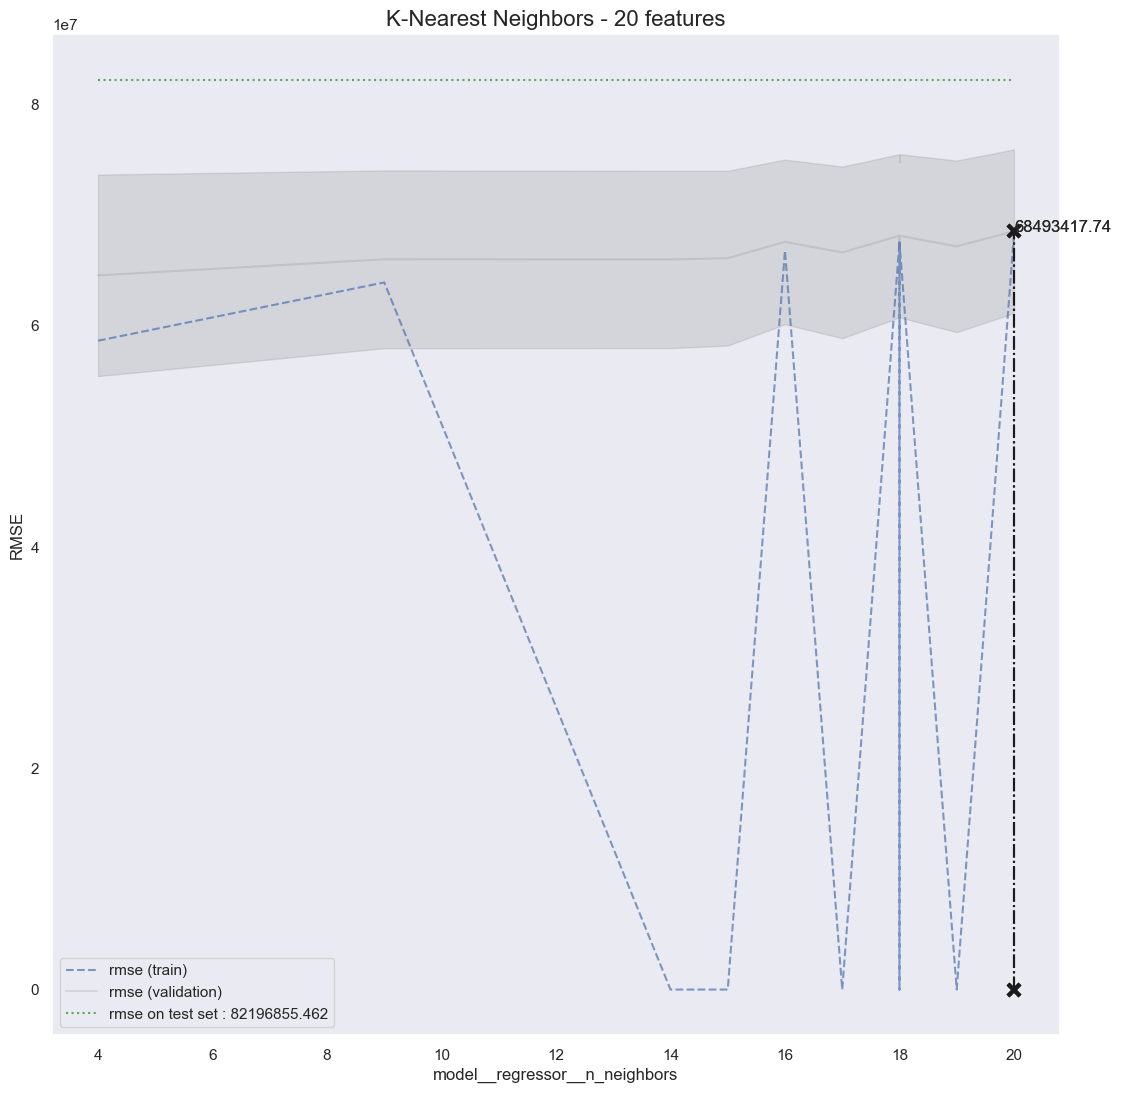

In [39]:
evaluate_model(KNN, knn_results)

### Multi-Layer Perceptron

In [19]:
MLP_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=MLPRegressor(), func=np.log1p, inverse_func=np.expm1))
])

MLP = {
	"name": "Multi-Layer Perceptron",
	"instance": MLP_pipe,
	"hyperparameters": {
		# doesn't seem to need to go over 3 layers
		"model__regressor__hidden_layer_sizes": [(10,),(25,),(25,25),(50,50),(25,50,25)],
		# relu seems the best
		"model__regressor__activation": ["identity", "logistic", "tanh", "relu"],
		# 1e-01 seems the best
		"model__regressor__alpha": [1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06], # https://scikit-learn.org/stable/modules/neural_networks_supervised.html,
		"model__regressor__max_iter": [1000]
	},
	#"n_iter": 12,
	"validation_param": "model__regressor__hidden_layer_sizes"
}

# bayesian search does not support tuple for hyperparameters search
# fallback to grid search
mlp_results = tune_model(model=MLP, search_type="gs")

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 5 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 10 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 15 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 20 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

In [80]:
pd.DataFrame.from_dict(mlp_results)

,features_kepts,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,5,(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'relu', 'mode...",1.645760e+08,1.453891e+08,100,"{'mean_fit_time': [2.237831163406372, 0.791222..."
1,10,(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'relu', 'mode...",7.083347e+08,1.918223e+08,97,"{'mean_fit_time': [1.2697549343109131, 0.62139..."
2,15,(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'relu', 'mode...",2.502917e+09,1.938978e+08,99,"{'mean_fit_time': [1.452365255355835, 0.692321..."
3,20,(TransformedTargetRegressor(func=<ufunc 'log1p...,"{'model__regressor__activation': 'relu', 'mode...",4.252973e+08,4.855894e+08,105,"{'mean_fit_time': [1.3915930271148682, 0.68144..."


[7.52559417e+07 7.53886888e+07 7.55675600e+07 7.55205936e+07
 7.58823564e+07 7.53010272e+07 7.52702976e+07 7.50922774e+07
 7.53023768e+07 7.56333180e+07 7.52895472e+07 7.51744202e+07
 7.52742124e+07 7.50784041e+07 7.52369818e+07 7.52649720e+07
 7.59060679e+07 7.53431575e+07 7.55557653e+07 7.54512641e+07
 7.52641889e+07 7.51604294e+07 7.56356017e+07 7.48738808e+07
 7.58904121e+07 7.51315309e+07 7.53440342e+07 7.54448894e+07
 7.49431592e+07 7.52720834e+07 7.14519105e+07 6.72487064e+07
 6.81588211e+07 7.81789040e+07 7.81808534e+07 7.14848145e+07
 6.75711713e+07 6.82429160e+07 7.41511938e+07 7.81819563e+07
 7.14015667e+07 6.73140492e+07 6.84942986e+07 7.24462411e+07
 7.81827545e+07 7.14935227e+07 6.70760049e+07 6.84278406e+07
 7.43274419e+07 7.81833360e+07 7.16938525e+07 6.71381466e+07
 6.83488911e+07 7.20861985e+07 7.81828177e+07 7.13814072e+07
 6.73448965e+07 6.85078340e+07 7.20637162e+07 7.81830895e+07
 7.03657483e+07 6.55898286e+07 6.56993193e+07 6.59635666e+07
 6.74765139e+07 7.117783

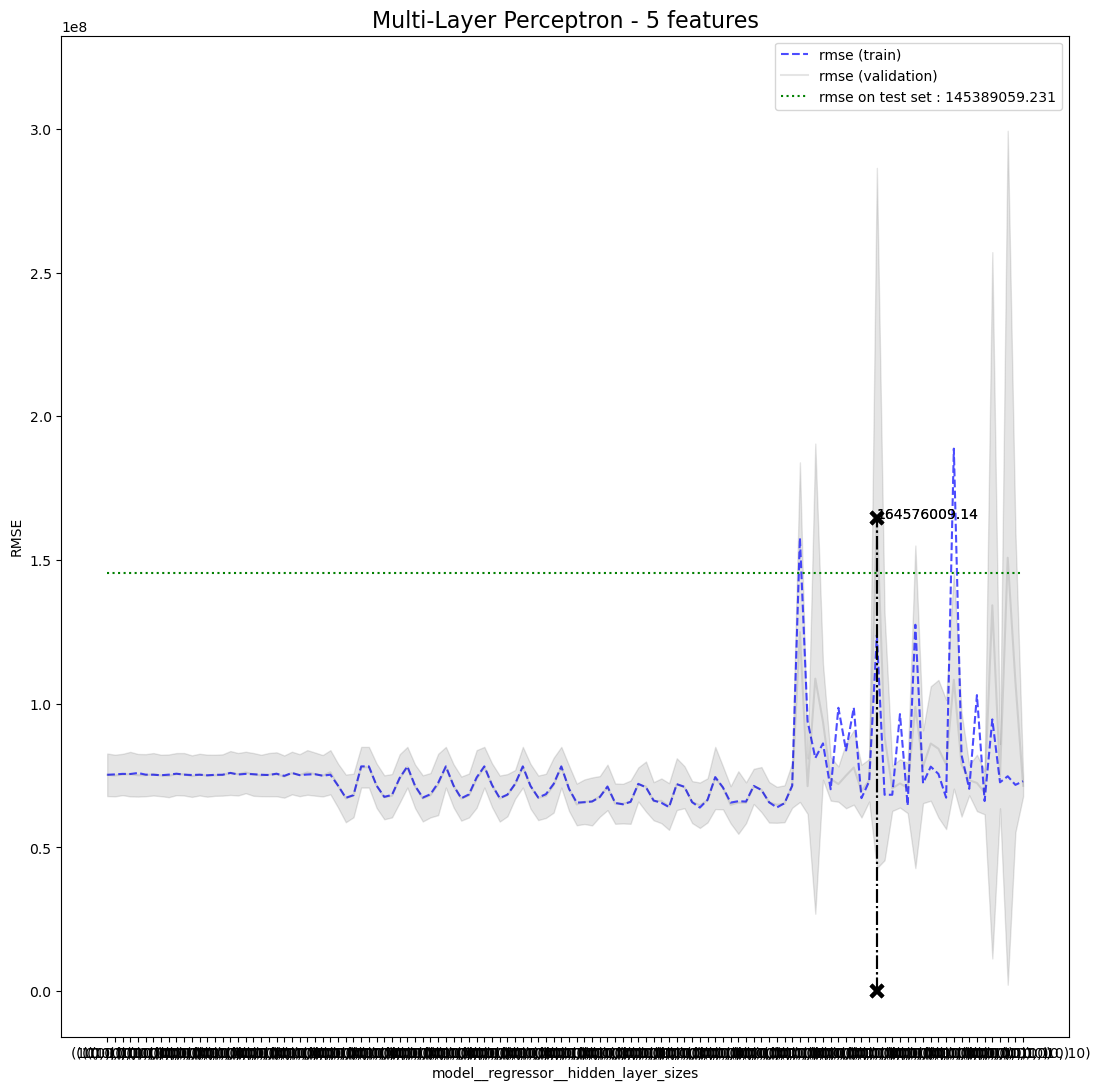

In [41]:
evaluate_model(MLP, mlp_results)

### Random Forest

#### Baseline

In [ ]:
n_fold = 0 
oof_rmse = 0

pred_rf_test = np.zeros(len(X2))

for train_index, val_index in kf.split(X_train, y_train):
    X_train_stra, X_val_stra = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
    y_train_stra, y_val_stra = y_train.iloc[train_index], y_train.iloc[val_index]
    
    print()
    print(f"Fold: {n_fold}")
    print()
    
    # setting up a basic random forest
    random_forest_pipe = Pipeline([
		("model", TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42, n_estimators=100), func=np.log1p, inverse_func=np.expm1))
	])
    
    # train the model on the stratified k-fold training set
    random_forest_pipe.fit(X_train_stra, y_train_stra)
    
    # predict regression on the whole test set
    pred = random_forest_pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=pred))
    print(f"Fold {n_fold} -- test RMSE: {rmse}")
    
    n_fold += 1
    oof_rmse += rmse
    
    pred_rf_test += random_forest_pipe.predict(X2[X_train.columns]) / N_SPLITS
  
print(f"Out-of-fold RMSE: {oof_rmse / N_SPLITS}")

fig, ax = plt.subplots(2, figsize=(12, 7))
sns.set(rc={"figure.figsize": (9, 14)})

sns.distplot(y_train, ax=ax[0])
sns.distplot(pred_rf_test, ax=ax[1])
fig.tight_layout()

#### Tuning

In [15]:
random_forest_pipe = Pipeline([
	("model", TransformedTargetRegressor(regressor=RandomForestRegressor(random_state=42), func=np.log1p, inverse_func=np.expm1))
])

rf = {
	"name": "Random Forest",
	"instance": random_forest_pipe,
	"hyperparameters": {
		"model__regressor__n_estimators": (35, 100),
		"model__regressor__criterion": ["absolute_error"], #["squared_error", "absolute_error", "poisson"],
		"model__regressor__max_depth": (7, 12), #[3, 5, 7, 10, 12, None] # none means unbounded max depth
		"model__regressor__min_samples_split": (2, 20),
    	"model__regressor__min_samples_leaf": (1, 20)
	},
	"n_iter": 12,
	"validation_param": "model__regressor__n_estimators"
}

rf_results = tune_model(model=rf, search_type="bs")

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 5 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: Th

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 10 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: Th

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 15 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: Th

-------------------------
FEATURE SELECTION (MUTUAL INFORMATION)...
-------------------------
reduced from 62 features to 20 features


/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/mathieu/opt/anaconda3/envs/env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: Th

In [17]:
pd.DataFrame.from_dict(rf_results)

,features_kepts,features,best_estimators,hyperparameters,val_scores,test_scores,best_iter_indexes,cv_results
0,5,"[n_votes, production_year, runtime, release_ye...",(TransformedTargetRegressor(func=<ufunc 'log1p...,{'model__regressor__criterion': 'absolute_erro...,6.535224e+07,7.594798e+07,11,"{'mean_fit_time': [7.8446431159973145, 9.81381..."
1,10,"[n_votes, production_year, runtime, release_ye...",(TransformedTargetRegressor(func=<ufunc 'log1p...,{'model__regressor__criterion': 'absolute_erro...,6.538909e+07,7.591205e+07,11,"{'mean_fit_time': [6.564845561981201, 9.553328..."
2,15,"[n_votes, production_year, runtime, release_ye...",(TransformedTargetRegressor(func=<ufunc 'log1p...,{'model__regressor__criterion': 'absolute_erro...,6.558971e+07,7.626248e+07,13,"{'mean_fit_time': [11.617015075683593, 18.4718..."
3,20,"[n_votes, production_year, runtime, release_ye...",(TransformedTargetRegressor(func=<ufunc 'log1p...,{'model__regressor__criterion': 'absolute_erro...,6.575670e+07,7.645632e+07,12,"{'mean_fit_time': [15.557097053527832, 23.2389..."


[ 35.  35.  35.  35.  35.  35.  35.  35.  35.  47.  56.  60.  69.  73.
  74.  79.  87.  91.  94. 100.]
[62950598.56936311 62950598.56936311 62950598.56936311 62950598.56936311
 62866804.37249196 62950598.56936311 62950598.56936311 62950598.56936311
 62866804.37249196 55546646.66069099 60253420.45811693 62355614.11368309
 61388205.13415732 61782335.54484567 59234839.35784557 62563180.16289908
 55752122.55797464 58942536.63066828 60904731.34937195 62830913.14200869]
[66844818.73310106 66844818.73310106 66844818.73310106 66844818.73310106
 66793061.94866407 66844818.73310106 66844818.73310106 66844818.73310106
 66793061.94866407 58358674.56019388 64043433.75677574 66432930.84566261
 65102413.07654323 65815672.13499187 62465407.86916201 66698158.56692806
 58422756.38954649 61853564.93247534 64647179.32134634 66916140.9025557 ]
[ 35.  35.  35.  35.  35.  35.  35.  35.  35.  47.  56.  60.  69.  73.
  74.  79.  87.  91.  94. 100.]
[58116288.28974003 58116288.28974003 58116288.28974003 5811628

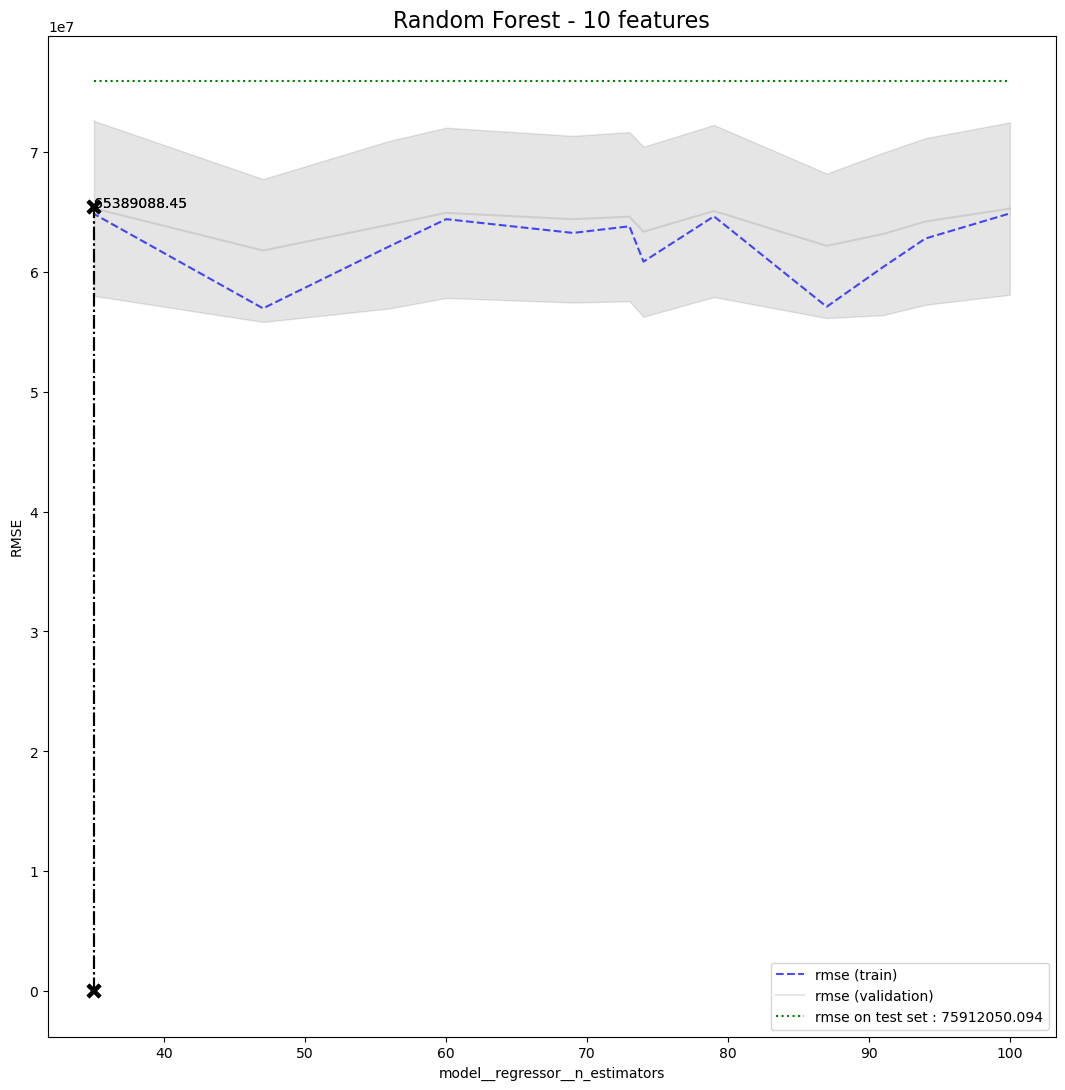

In [18]:
evaluate_model(rf, rf_results)

## Prediction

We're gonna make prediction about the revenue of movies present in `X2.csv`.

['n_votes', 'production_year', 'runtime', 'release_year', 'studio_Uni.', 'studio_BV', 'studio_WB', 'studio_SPC', 'genre_Action', 'genre_Adventure']


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

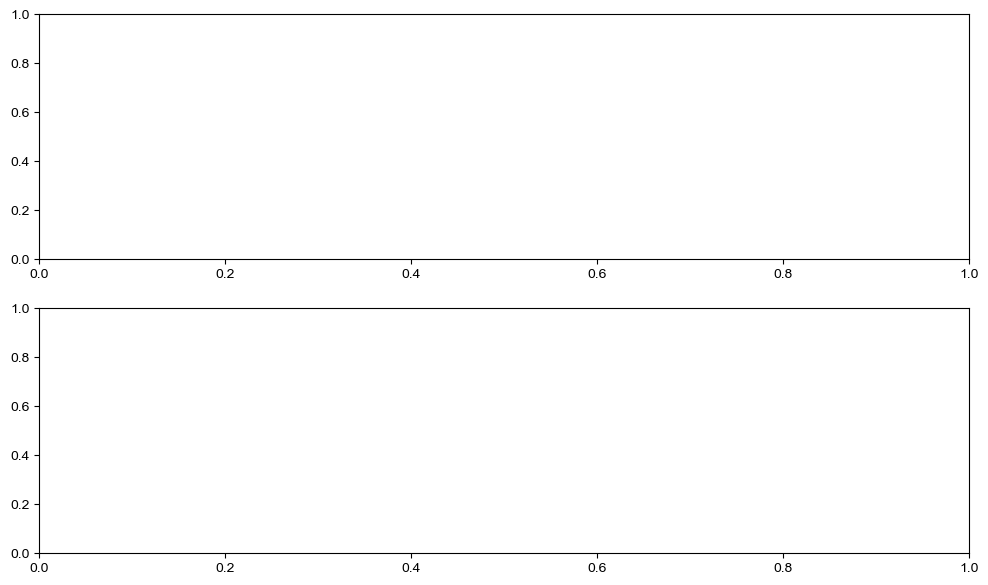

In [19]:
fig, ax = plt.subplots(2, figsize=(12,7))
sns.set(rc={"figure.figsize": (9, 14)})

best_model = rf_results["best_estimators"][np.argmin(rf_results["test_scores"])]
features = rf_results["features"][np.argmin(rf_results["test_scores"])]
print(features)

Y2 = best_model.predict(X2[features])

sns.histplot(Y, ax=ax[0])
sns.histplot(Y2, ax=ax[1])
fig.tight_layout()

In [82]:
X2.shape

(1425, 62)